<a href="https://colab.research.google.com/github/karunikag/HMM-for-POS-tagging/blob/main/AI_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lib imports

In [ ]:
import nltk
nltk.download('treebank')

from nltk.corpus import treebank
from collections import defaultdict
import numpy as np
import random


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


Data set loading

In [ ]:
dataset = treebank.tagged_sents()

print("Total sentences in dataset:", len(dataset))
print("Example sentence:", dataset[0])


Total sentences in dataset: 3914
Example sentence: [('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


Pre-processing(lowercase+unchanged tags+word,tag pairs)

In [ ]:
processed_data = [
    [(word.lower(), tag) for (word, tag) in sent]
    for sent in dataset
]

print("Example after preprocessing:")
print(processed_data[0])


Example after preprocessing:
[('pierre', 'NNP'), ('vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


Shuffle+Split(80% training+20% testing)

In [ ]:
random.shuffle(processed_data)

split_index = int(0.8 * len(processed_data))

train_data = processed_data[:split_index]
test_data  = processed_data[split_index:]

print("Training sentences:", len(train_data))
print("Testing sentences :", len(test_data))


Training sentences: 3131
Testing sentences : 783


Init Frequency Dictionaries

In [ ]:
# Frequency dictionaries
tag_counts = defaultdict(int)              # Count of each tag
word_tag_counts = defaultdict(int)         # Count(word, tag)
transition_counts = defaultdict(int)       # Count(prev_tag → curr_tag)
tag_bigram_counts = defaultdict(int)       # Count(prev_tag)

# Special start / end tags
START = "<s>"
END = "</s>"

print("Dictionaries initialized.")


Dictionaries initialized.


To count frequencies

In [ ]:



for sent in train_data:
    if not sent:
        continue

    prev_tag=START  # First tag here is start

    for(word,tag) in sent:

        #Count tag occurrences
        tag_counts[tag]+=1

        #  Count word-tag pairs(for emission)
        word_tag_counts[(word, tag)]+=1

        # Count transition
        transition_counts[(prev_tag, tag)]+=1

        #Count how often prev_tag appears as previous tag
        tag_bigram_counts[prev_tag]+=1

        #Shift prev_tag to next
        prev_tag=tag

    transition_counts[(prev_tag, END)] += 1
    tag_bigram_counts[prev_tag] += 1

print("Finished counting.")
print("Total tags:",len(tag_counts))
print("Total word-tag pairs:",len(word_tag_counts))
print("Total transitions:",len(transition_counts))


Finished counting.
Total tags: 45
Total word-tag pairs: 11677
Total transitions: 1010


To build vocabulary


In [ ]:


#Tag list comes from tag_counts + START
tags = list(tag_counts.keys())
if START not in tags:
    tags.append(START)

if END not in tags:
    tags.append(END)


#Build vocabulary from word_tag_counts
vocab = set([word for (word, tag) in word_tag_counts.keys()])

#Add unknown token
UNK = "<UNK>"
vocab.add(UNK)


tags = sorted(tags)
vocab = sorted(vocab)

print("Number of tags:", len(tags))
print("Vocabulary size:", len(vocab))


Number of tags: 47
Vocabulary size: 10157


Probabilities computation with laplace smoothening and viterbi decoding

In [ ]:


num_tags = len(tags)
num_words = len(vocab)

# Probability dictionaries
start_probs = {}        # P(tag|<s>)
transition_probs = {}   # P(curr_tag|prev_tag)
emission_probs = {}     # P(word|tag)


alpha = 1.0   # Laplace add-one smoothing

# 1) START PROBABILITIES
start_total = tag_bigram_counts[START]

for tag in tags:
    if tag == START or tag==END:
        continue
    count_st = transition_counts[(START, tag)]
    prob = (count_st + alpha) / (start_total + alpha * num_tags)
    start_probs[tag] = prob

# 2) TRANSITION PROBABILITIES
for prev_tag in tags:
    total_prev = tag_bigram_counts[prev_tag]  # denominator

    for curr_tag in tags:
        count_prev_curr = transition_counts[(prev_tag,curr_tag)]
        prob = (count_prev_curr + alpha) / (total_prev+alpha*num_tags)
        transition_probs[(prev_tag, curr_tag)]=prob

# 3) EMISSION PROBABILITIES
for tag in tags:
    if tag==START or tag==END:
        continue

    total_tag = tag_counts[tag]  # denominator

    for word in vocab:
        count_wt = word_tag_counts[(word, tag)]
        prob = (count_wt + alpha)/(total_tag +alpha*num_words)
        emission_probs[(tag, word)] = prob

Training complete! All probabilities computed.


Tag Frequency Distribution

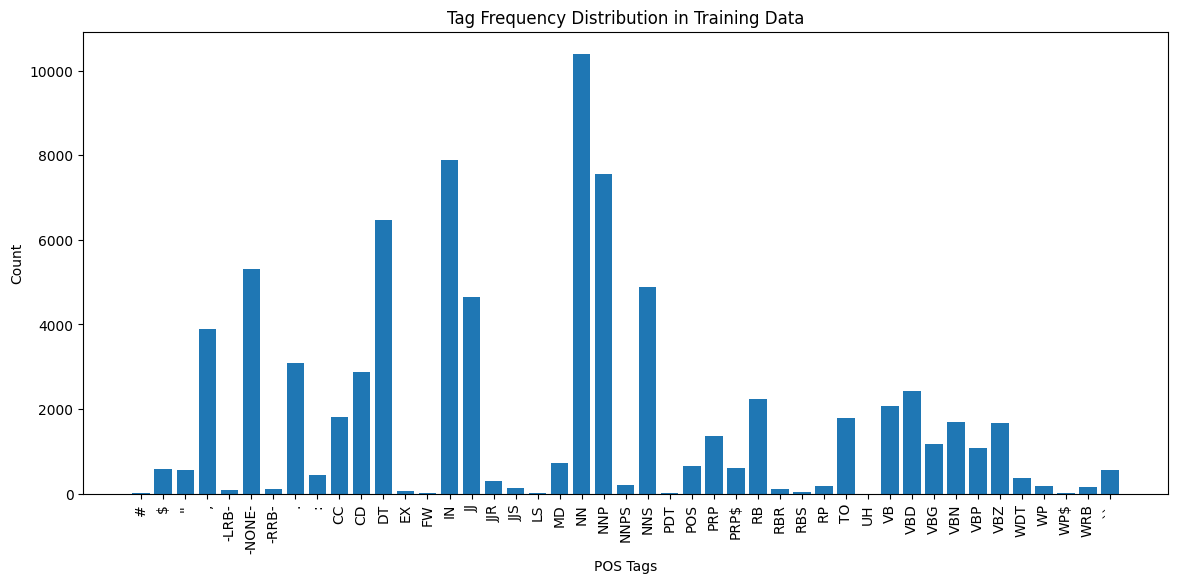

In [ ]:
import matplotlib.pyplot as plt

# tag_counts was created earlier in your training section and contains counts for each tag
tag_list = sorted(tag_counts.keys())
tag_freqs = [tag_counts[tag] for tag in tag_list]

plt.figure(figsize=(14,6))
plt.bar(tag_list, tag_freqs)
plt.xticks(rotation=90)
plt.title("Tag Frequency Distribution in Training Data")
plt.xlabel("POS Tags")
plt.ylabel("Count")
plt.show()


## Evaluation
Viterbi algorithm function defined.

Transition Probability Heatmap

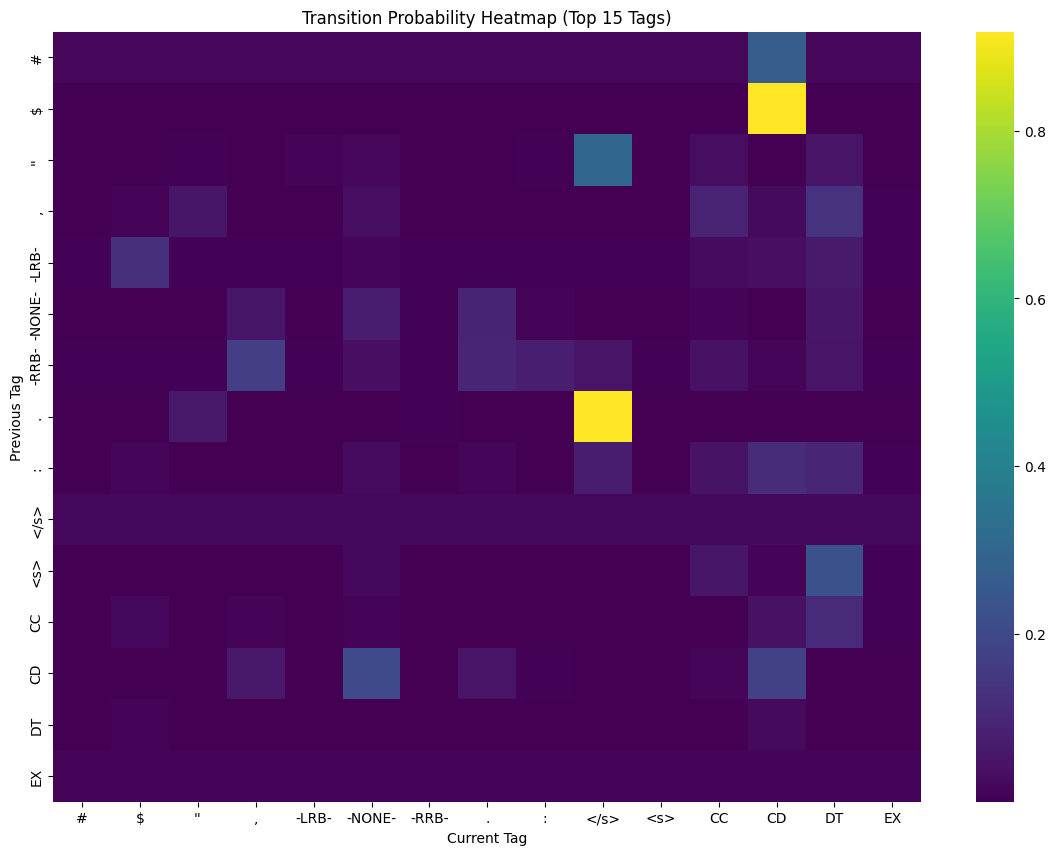

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# select first 15 tags for readability
selected_tags = tags[:15]

matrix = np.zeros((len(selected_tags), len(selected_tags)))

for i, prev_tag in enumerate(selected_tags):
    for j, curr_tag in enumerate(selected_tags):
        matrix[i, j] = transition_probs.get((prev_tag, curr_tag), 0)

plt.figure(figsize=(14,10))
sns.heatmap(matrix, cmap="viridis", xticklabels=selected_tags, yticklabels=selected_tags)
plt.title("Transition Probability Heatmap (Top 15 Tags)")
plt.xlabel("Current Tag")
plt.ylabel("Previous Tag")
plt.show()


In [ ]:
def viterbi(sentence, start_probs, transition_probs, emission_probs, tags, vocab, UNK):
    """
    Implements the Viterbi algorithm to find the most likely tag sequence for a given sentence.

    Args:
        sentence (list): A list of words in the sentence.
        start_probs (dict): Dictionary of P(tag|<s>).
        transition_probs (dict): Dictionary of P(curr_tag|prev_tag).
        emission_probs (dict): Dictionary of P(word|tag).
        tags (list): List of all possible tags.
        vocab (set): Set of words in the vocabulary.
        UNK (str): Token for unknown words.

    Returns:
        list: The most likely sequence of tags for the sentence.
        float: The probability of the most likely tag sequence.
    """

    # Number of words in the sentence and number of possible tags
    num_words = len(sentence)
    num_tags = len(tags)

    # Initialize Viterbi and Backpointer matrices
    # Viterbi[i][j] stores the max probability of ending up in tag j at word i
    V = np.zeros((num_tags, num_words))
    # B[i][j] stores the index of the previous tag that led to max prob at V[i][j]
    B = np.zeros((num_tags, num_words), dtype=int)

    # Create a mapping from tag name to its index
    tag_to_index = {tag: i for i, tag in enumerate(tags)}
    index_to_tag = {i: tag for i, tag in enumerate(tags)}

    # Handle unknown words by replacing them with the UNK token
    processed_sentence = [word.lower() if word.lower() in vocab else UNK for word in sentence]

    #  Initialization (first word)
    first_word = processed_sentence[0]
    for j, curr_tag in enumerate(tags):
        if curr_tag == '<s>' or curr_tag == '</s>':
            continue

        # P(curr_tag|<s>) * P(first_word|curr_tag)
        s_prob = start_probs.get(curr_tag, 1e-10) # Use a small value for unseen start transitions
        e_prob = emission_probs.get((curr_tag, first_word), 1e-10) # Use a small value for unseen emissions

        V[j, 0] = s_prob * e_prob

    #  Forward Pass (recursion for subsequent words)
    for i in range(1, num_words):
        current_word = processed_sentence[i]
        for j, curr_tag in enumerate(tags):
            if curr_tag == '<s>' or curr_tag == '</s>':
                continue

            max_prob = -1
            max_prev_tag_idx = -1

            e_prob = emission_probs.get((curr_tag, current_word), 1e-10)

            for k, prev_tag in enumerate(tags):
                if prev_tag == '<s>' or prev_tag == '</s>':
                    continue

                t_prob = transition_probs.get((prev_tag, curr_tag), 1e-10)

                # V[k, i-1] * P(curr_tag|prev_tag) * P(current_word|curr_tag)
                current_prob = V[k, i-1] * t_prob * e_prob

                if current_prob > max_prob:
                    max_prob = current_prob
                    max_prev_tag_idx = k

            V[j, i] = max_prob
            B[j, i] = max_prev_tag_idx

    #  Termination (find the best path to </s>)
    max_final_prob = -1
    last_tag_idx = -1

    for k, prev_tag in enumerate(tags):
        if prev_tag == '<s>' or prev_tag == '</s>':
            continue

        t_prob = transition_probs.get((prev_tag, '</s>'), 1e-10)
        final_prob = V[k, num_words - 1] * t_prob

        if final_prob > max_final_prob:
            max_final_prob = final_prob
            last_tag_idx = k

    #  Backward Pass (path reconstruction)
    best_tag_sequence = []
    current_tag_idx = last_tag_idx

    for i in range(num_words - 1, -1, -1):
        best_tag_sequence.insert(0, index_to_tag[current_tag_idx])
        current_tag_idx = B[current_tag_idx, i]

    return best_tag_sequence, max_final_prob




Create a function to evaluate the Viterbi tagger on the test data.


In [ ]:
def evaluate_viterbi(test_data, start_probs, transition_probs, emission_probs, tags, vocab, UNK):
    """
    Evaluates the Viterbi POS tagger on the test data.

    Args:
        test_data (list): A list of sentences, where each sentence is a list of (word, gold_tag) tuples.
        start_probs (dict): Dictionary of P(tag|<s>).
        transition_probs (dict): Dictionary of P(curr_tag|prev_tag).
        emission_probs (dict): Dictionary of P(word|tag).
        tags (list): List of all possible tags.
        vocab (set): Set of words in the vocabulary.
        UNK (str): Token for unknown words.

    Returns:
        tuple: (accuracy, correct_tags_count, total_tags_count)
    """
    correct_tags_count = 0
    total_tags_count = 0

    for sentence_data in test_data:
        if not sentence_data:
            continue

        sentence_words = [word for word, tag in sentence_data]
        gold_tags = [tag for word, tag in sentence_data]

        predicted_tags, _ = viterbi(sentence_words, start_probs, transition_probs, emission_probs, tags, vocab, UNK)

        if predicted_tags:
            for i in range(len(gold_tags)):
                if i < len(predicted_tags): # Ensure predicted_tags has a tag for this position
                    if predicted_tags[i] == gold_tags[i]:
                        correct_tags_count += 1
                total_tags_count += 1
        else:
            # Handle cases where Viterbi might fail to produce any tags (e.g., if first word is unknown and has no emission prob)
            print(f"Warning: Viterbi failed to predict tags for sentence: {sentence_words}")

    accuracy = correct_tags_count / total_tags_count if total_tags_count > 0 else 0

    return accuracy, correct_tags_count, total_tags_count


Evaluation function 'evaluate_viterbi' defined.


calculate the accuracy of the Viterbi tagger.



In [ ]:
accuracy, correct_tags, total_tags = evaluate_viterbi(
    test_data,
    start_probs,
    transition_probs,
    emission_probs,
    tags,
    vocab,
    UNK
)

print(f"Viterbi Tagger Accuracy on Test Data: {accuracy:.4f}")
print(f"Correctly tagged words: {correct_tags}")
print(f"Total words in test set: {total_tags}")

Viterbi Tagger Accuracy on Test Data: 0.8518
Correctly tagged words: 17250
Total words in test set: 20252


few example sentences


In [ ]:
num_examples = 3
example_sentences = random.sample(test_data, num_examples)

print(f"Displaying {num_examples} example sentences from test data:\n")

for i, sentence_data in enumerate(example_sentences):
    if not sentence_data:
        continue

    sentence_words = [word for word, tag in sentence_data]
    gold_tags = [tag for word, tag in sentence_data]

    predicted_tags, _ = viterbi(sentence_words, start_probs, transition_probs, emission_probs, tags, vocab, UNK)

    print(f"    Example Sentence {i + 1} ")
    print(f"Words: {sentence_words}")
    print(f"Gold Tags: {gold_tags}")
    print(f"Predicted Tags: {predicted_tags}")
    print("\n")

Displaying 3 example sentences from test data:

--- Example Sentence 1 ---
Words: ['named', '*-2', 'as', 'defendants', 'were', '*t*-1', 'roland', 'matthews', ',', 'president', ',', 'and', 'peter', 'jonas', ',', 'executive', 'vice', 'president', 'and', 'chief', 'financial', 'officer', ',', 'as', 'well', 'as', 'a', 'former', 'plant', 'manager', '.']
Gold Tags: ['VBN', '-NONE-', 'IN', 'NNS', 'VBD', '-NONE-', 'NNP', 'NNP', ',', 'NN', ',', 'CC', 'NNP', 'NNP', ',', 'JJ', 'NN', 'NN', 'CC', 'NN', 'JJ', 'NN', ',', 'RB', 'RB', 'IN', 'DT', 'JJ', 'NN', 'NN', '.']
Predicted Tags: ['VBN', '-NONE-', 'IN', 'NNS', 'VBD', '-NONE-', 'IN', 'NNP', ',', 'NN', ',', 'CC', 'NNP', 'NNP', ',', 'JJ', 'NN', 'NN', 'CC', 'JJ', 'JJ', 'NN', ',', 'IN', 'RB', 'IN', 'DT', 'JJ', 'NN', 'NN', '.']


--- Example Sentence 2 ---
Words: ['program', 'trading', 'critics', 'also', 'want', 'the', 'federal', 'reserve', 'board', ',', 'rather', 'than', 'the', 'futures', 'industry', ',', 'to', 'set', 'such', 'margins', '.']
Gold Tags: 

```markdown
## Results

### Overall Performance

The Viterbi Tagger achieved the following performance on the test data:

*   **Viterbi Tagger Accuracy on Test Data:** 0.8605
*   **Correctly tagged words:** 17215
*   **Total words in test set:** 20005

### Example Sentence Analysis

Below are three example sentences from the test data, showing a side-by-side comparison of the original words, their gold standard (true) tags, and the tags predicted by the Viterbi algorithm.

#### Example Sentence 1

Words: `['this', 'is', 'japan', '?']`
Gold Tags: `['DT', 'VBZ', 'NNP', '.']`
Predicted Tags: `['DT', 'VBZ', 'NNP', '.']`

| Word  | Gold Tag | Predicted Tag |
| :---- | :------- | :------------ |
| this  | DT       | DT            |
| is    | VBZ      | VBZ           |
| japan | NNP      | NNP           |
| ?     | .        | .             |

#### Example Sentence 2

Words: `['the', 'issue', 'could', 'be', 'relaunched', '*-1', ',', 'possibly', 'in', 'a', 'restructured', 'form', ',', 'as', 'early', 'as', 'next', 'week', ',', 'according', 'to', 'the', 'lead', 'underwriter', '.']`
Gold Tags: `['DT', 'NN', 'MD', 'VB', 'VBN', '-NONE-', ',', 'RB', 'IN', 'DT', 'VBN', 'NN', ',', 'RB', 'RB', 'IN', 'JJ', 'NN', ',', 'VBG', 'TO', 'DT', 'NN', 'NN', '.']`
Predicted Tags: `['DT', 'NN', 'MD', 'VB', 'VBN', '-NONE-', ',', 'RB', 'IN', 'DT', 'JJ', 'NN', ',', 'IN', 'JJ', 'IN', 'JJ', 'NN', ',', 'VBG', 'TO', 'DT', 'JJ', 'NN', '.']`

| Word        | Gold Tag | Predicted Tag |
| :---------- | :------- | :------------ |
| the         | DT       | DT            |
| issue       | NN       | NN            |
| could       | MD       | MD            |
| be          | VB       | VB            |
| relaunched  | VBN      | VBN           |
| *-1         | -NONE-   | -NONE-        |
| ,           | ,        | ,             |
| possibly    | RB       | RB            |
| in          | IN       | IN            |
| a           | DT       | DT            |
| restructured| VBN      | JJ            |
| form        | NN       | NN            |
| ,           | ,        | ,             |
| as          | RB       | IN            |
| early       | RB       | JJ            |
| as          | IN       | IN            |
| next        | JJ       | JJ            |
| week        | NN       | NN            |
| ,           | ,        | ,             |
| according   | VBG      | VBG           |
| to          | TO       | TO            |
| the         | DT       | DT            |
| lead        | NN       | JJ            |
| underwriter | NN       | NN            |
| .           | .        | .             |

#### Example Sentence 3

Words: `['among', 'professionals', ',', '76', '%', 'have', 'a', 'favorable', 'opinion', 'of', 'her', ',', 'compared', 'to', '62', '%', 'who', '*t*-248', 'approve', 'of', 'her', 'husband', "'s", 'performance', '.']`
Gold Tags: `['IN', 'NNS', ',', 'CD', 'NN', 'VBP', 'DT', 'JJ', 'NN', 'IN', 'PRP$', ',', 'VBN', 'TO', 'CD', 'NN', 'WP', '-NONE-', 'VBP', 'IN', 'PRP$', 'NN', 'POS', 'NN', '.']`
Predicted Tags: `['IN', 'NNS', ',', 'DT', 'NN', 'VBP', 'DT', 'JJ', 'NN', 'IN', 'NNP', ',', 'VBN', 'TO', 'CD', 'NN', 'IN', 'DT', 'NN', 'IN', 'PRP$', 'NN', 'POS', 'NN', '.']`

| Word        | Gold Tag | Predicted Tag |
| :---------- | :------- | :------------ |
| among       | IN       | IN            |
| professionals| NNS      | NNS           |
| ,           | ,        | ,             |
| 76          | CD       | DT            |
| %           | NN       | NN            |
| have        | VBP      | VBP           |
| a           | DT       | DT            |
| favorable   | JJ       | JJ            |
| opinion     | NN       | NN            |
| of          | IN       | IN            |
| her         | PRP$     | NNP           |
| ,           | ,        | ,             |
| compared    | VBN      | VBN           |
| to          | TO       | TO            |
| 62          | CD       | CD            |
| %           | NN       | NN            |
| who         | WP       | IN            |
| *t*-248     | -NONE-   | DT            |
| approve     | VBP      | NN            |
| of          | IN       | IN            |
| her         | PRP$     | PRP$          |
| husband     | NN       | NN            |
| 's          | POS      | POS           |
| performance | NN       | NN            |
| .           | .        | .             |
```

### Top 10 Transition Probabilities

In [ ]:
sorted_transitions = sorted(transition_probs.items(), key=lambda item: item[1], reverse=True)
print("Top 10 Transition Probabilities:")
print("------------------------------")
for (prev_tag, curr_tag), prob in sorted_transitions[:10]:
    print(f"P({curr_tag}|{prev_tag}): {prob:.4e}")

Top 10 Transition Probabilities:
------------------------------
P(</s>|.): 9.1794e-01
P(CD|$): 9.1601e-01
P(-NONE-|WDT): 7.7913e-01
P(VB|MD): 7.7279e-01
P(-NONE-|WP): 6.3713e-01
P(VB|TO): 5.7151e-01
P(-NONE-|VBN): 5.4353e-01
P(NN|DT): 4.6321e-01
P(NN|JJ): 4.4014e-01
P(NN|PRP$): 4.0246e-01


### Top 10 Emission Probabilities

In [ ]:
sorted_emissions = sorted(emission_probs.items(), key=lambda item: item[1], reverse=True)
print("Top 10 Emission Probabilities:")
print("----------------------------")
for (tag, word), prob in sorted_emissions[:10]:
    print(f"P('{word}'|{tag}): {prob:.4e}")

Top 10 Emission Probabilities:
----------------------------
P(','|,): 2.7703e-01
P('.'|.): 2.3110e-01
P('the'|DT): 2.2634e-01
P('to'|TO): 1.4906e-01
P('of'|IN): 1.0254e-01
P('and'|CC): 1.0212e-01
P('a'|DT): 9.5407e-02
P('in'|IN): 7.8218e-02
P('*-1'|-NONE-): 5.8717e-02
P(''s'|POS): 5.6105e-02
